In [1]:
%load_ext autoreload
%autoreload 2
import enoki as ek
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')

import time
import torch
import cv2
import copy
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import wandb
from mitsuba.python.autodiff import render, render_torch, write_bitmap
from mitsuba.python.util import traverse
from mitsuba.core.xml import load_file
from mitsuba.core import Thread, Vector3f


from torch_openpose.body import Body
from torch_openpose import util

In [2]:
def wandb_init(name):
    run = wandb.init(
        project = "mts_single_image_texture", 
        reinit = True,
        name = name,
        config={
            "steps": 1000,
            "epsilon": 5000,
            "noise_width": 200,
            "noise_height": 400,
        }
    )
    
    return run 

cuda:0


2020-03-31 18:43:01 INFO main [xml.cpp:1117] Loading XML file "pose_scene/scene.xml" ..

2020-03-31 18:43:01 INFO main [xml.cpp:1118] Using variant "gpu_autodiff_rgb"

2020-03-31 18:43:01 INFO main [xml.cpp:348] "pose_scene/scene.xml": in-memory version upgrade (v0.6.0 -> v2.0.0) ..

2020-03-31 18:43:01 INFO main [PluginManager] Loading plugin "plugins/uniform.so" ..

2020-03-31 18:43:01 INFO main [PluginManager] Loading plugin "plugins/direct.so" ..

2020-03-31 18:43:01 INFO main [PluginManager] Loading plugin "plugins/bitmap.so" ..

2020-03-31 18:43:01 INFO main [PluginManager] Loading plugin "plugins/diffuse.so" ..

2020-03-31 18:43:01 INFO main [PluginManager] Loading plugin "plugins/serialized.so" ..

2020-03-31 18:43:01 INFO main [PluginManager] Loading plugin "plugins/obj.so" ..

2020-03-31 18:43:01 INFO main [PluginManager] Loading plugin "plugins/constant.so" ..

2020-03-31 18:43:01 INFO main [PluginManager] Loading plugin "plugins/independent.so" ..

2020-03-31 18:43:01 INFO main [PluginManager] Loading plugin "plugins/box.so" ..

2020-03-31 18:43:01 INFO main [PluginManager] Loading plugin "plugins/hdrfilm.so" ..

2020-03-31 18:43:01 INFO main [PluginManager] Loading plugin "plugins/perspective.so" ..

2020-03-31 18:43:01 INFO main [Scene] Validating and building scene in OptiX.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 431.5, 367.5, -0.5)

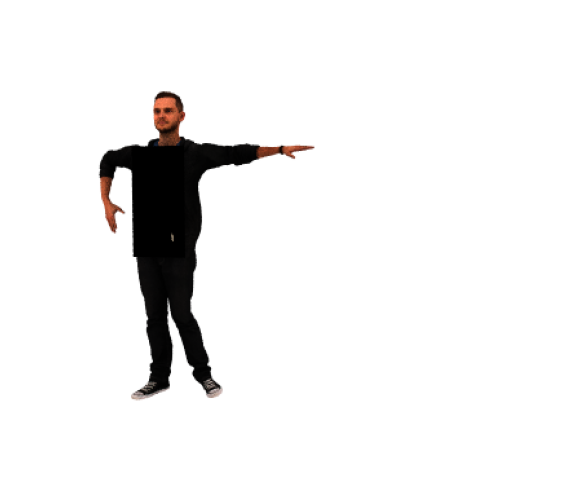

In [3]:
STRIDE = 8
PAD_VALUE = 128
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
ORIG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

body_estimation = Body(
    '/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Thread.thread().file_resolver().append('pose_scene')
scene = load_file('pose_scene/scene.xml')

# Find differentiable scene parameters
params = traverse(scene)
# print(params)


# Render a reference image (no derivatives used yet)
rendering_torch = render_torch(scene, spp=32)

# make torch RGB to BGR
PERMUTE_BGR = [2, 1, 0]
rendering_torch_BGR = rendering_torch[:, :, PERMUTE_BGR]
# permute and stack
rendering_torch_input = torch.stack([rendering_torch_BGR.permute((2, 0, 1))  - 0.5])

canvas = rendering_torch_BGR.cpu().detach().numpy() 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(canvas[:, :, [2, 1, 0]])
ax.axis('off')

In [4]:
print(params_torch[diff_parameter].shape)
print(200*400 *3)

torch.Size([240000])
240000


In [5]:
# Construct a PyTorch Adam optimizer that will adjust 'params_torch'
opt = torch.optim.Adam(params_torch.values(), lr=.2)
objective = torch.nn.MSELoss()
#ek.set_requires_gradient(params[diff_parameter])

In [6]:
for steps 
joint_id = 4
# Zero out gradients before each iteration
opt.zero_grad()
body_estimation.model.zero_grad()

# render image
# maybe add malloc_trim=True if memory issues
cur_rednering_torch = render_torch(scene, params=params, unbiased=True, spp=16, **params_torch)

# transform from rgb to bgr
PERMUTE_BGR = [2, 1, 0]
rendering_torch_BGR = cur_rednering_torch[:, :, PERMUTE_BGR]

# permute channels to pytorch order and stack
rendering_torch_input = torch.stack([rendering_torch_BGR.permute((2, 0, 1))  - 0.5])

print(rendering_torch_input.shape)

# compute the avg heatmap and paf map
paf, heatmap = body_estimation.model(rendering_torch_input)

# get the joint heatmap of the joint id
joint_heatmap = heatmap[0, joint_id]


single_zero_heatmap = torch.zeros((46, 54), device=device)
ob_val = objective(joint_heatmap, single_zero_heatmap)
print(ob_val)
ob_val.backward()

print(params_torch[diff_parameter].grad)


torch.Size([1, 3, 368, 432])
tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward>)
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


In [7]:
noise_resolution  = np.array([200, 400])
grad_np = params_torch[diff_parameter].grad.cpu().detach().numpy()
grad_image = grad_np.reshape(noise_resolution[1], noise_resolution[0], -1)
print(np.min(grad_image))
print(np.max(grad_image))
print(type(params_torch[diff_parameter].grad).__name__)

-4.2721904e-06
4.1018807e-06
Tensor


In [4]:
run = wandb_init('second try')
noise_resolution  = np.array([200, 400])

diff_parameter = 'rect.bsdf.reflectance.data'
params.keep([diff_parameter])
params.update()
# Which parameters should be exposed to the PyTorch optimizer?
params_torch = params.torch()
print(params_torch)

# set up optimizer
opt = torch.optim.Adam(params_torch.values(), lr=.2)
objective = torch.nn.MSELoss()

# target
zero_heatmap = torch.zeros((1, 19, 46, 54), device=device)
zero_paf = torch.zeros((1, 38, 46, 54), device=device)

for step in tqdm(range(run.config.steps)):
    if step % 50 ==  0:
        write_bitmap('output/texture_%03i.png' % step, params_torch[diff_parameter], noise_resolution)
    opt.zero_grad()
    body_estimation.model.zero_grad()

    # render image
    # maybe add malloc_trim=True if memory issues
    cur_rednering_torch = render_torch(scene, params=params, unbiased=True, spp=16, **params_torch)

    # transform from rgb to bgr
    PERMUTE_BGR = [2, 1, 0]
    rendering_torch_BGR = cur_rednering_torch[:, :, PERMUTE_BGR]

    # permute channels to pytorch order and stack
    rendering_torch_input = torch.stack([rendering_torch_BGR.permute((2, 0, 1))  - 0.5])

    # compute the avg heatmap and paf map
    paf, heatmap = body_estimation.model(rendering_torch_input)

    
    ob_val_heat = objective(heatmap, zero_heatmap)
    ob_val_paf = objective(paf, zero_paf)
    ob_val = ob_val_heat + ob_val_paf
    
    # calc gradient
    ob_val.backward()
    
    # take a step in gradient direction
    opt.step()
    
    # log the loss
    wandb.log({'loss': ob_val.item()}, step=step)

    


  0%|          | 0/1000 [00:00<?, ?it/s]

{'rect.bsdf.reflectance.data': tensor([0.0003, 0.0003, 0.0003,  ..., 0.0006, 0.0006, 0.0006], device='cuda:0',
       requires_grad=True)}


100%|██████████| 1000/1000 [07:36<00:00,  2.19it/s]
